Partiamo da un problema di Classificazione binaria (2 classi). Risolveremo tale problema utilizzando un rete neurale.

Il dataset utilizzato è imdb, presente nel package di keras. E' un set di dati di 50.000 recensioni di film da IMDB, etichettati dal sentimento (positivo/ negativo). Le recensioni sono state preprocessate e ogni recensione è codificata come un elenco di indici di parole (numeri interi).

Partiamo con il caricare il dataset nel nostro workspace:

In [ ]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

print(len(train_data) + len(test_data))

50000


Ogni data points del dataset rappresenta una recensione processata; cioè un vettore di interi che rappresentano le parole utilizzate in quella determinata recensione.
Le label invece rappresentano valori booleani (0,1) che indicano se la recensione è negativa o positiva.

In [4]:
print(train_data[0]), print("\n")
print(train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


1


**Creiamo un mapping 1:1 tra le parole e gli indici in modo da conoscere a che parola corrisponde ogni indice**

Perchè i - 3? Nei dati originali, gli indici 0, 1 e 2 sono riservati a: padding(0), inizio sequenza(1), token sconosciuto(2)

**Quindi si sottrae 3 per mappare correttamente ai veri indici delle parole.**

In [15]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value,key) for (key,value) in word_index.items()])

#Mostriamo per esempio il testo originale della prima recensione
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]]
)

print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

Arrivati a questo punto non possiamo dare in input direttamente questi dati alla rete neurale, questo perchè i vari vettori (recensioni) hanno differenti lunghezze (le recensione non hanno sempre lo stesso numero di parole, quindi hanno differente lunghezza), inoltre, la rete neurale si aspetta di avere in input dei tensori, non devi vettori numerici. 

**Quindi dobbiamo gestire questi due aspetti prima di poter dare i dati in input alla rete.**

Per far questo utilizziamo la tecnica del **Multi-hot encoding**. Più precisamente, creiamo un **tensore di float di dimensione (NumRecensioni,GrandezzaVocabolario)**. In questo caso sappiamo che il vocabolario contiene 10.000 parole, quindi il tensore 2D avrà 10.000 colonne, e un numero di righe uguale al numero di recensioni. Così facendo avremo vettori della stessa grandezza (dimensione 10.000). I vettori "vecchi" verrano convertiti nei "nuovi" vettori di dimensione 10.000 tramite il multi-hot encoding. Cioè, data una recensione, il suo nuovo vettore avrà un valore 1 nella posizione i-esima se la recensione che stiamo considerando contiene la parola i-esima, 0 altrimenti.

Es: review = [15, 432, 123, 7]

Il nuovo vettore che rappresentà review avrà valori 1 in posizione 15,432,123 e 7, in modo da poter risalire alle parole che erano presenti nella recensione anche dopo l'encoding. Tutte le altre posizioni avranno valore 0.

In [19]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) #Inizialmente il tensore viene inizializzato con tutti valori 0
    for i, sequence in enumerate(sequences):
        for word in sequence:
          results[i, word] = 1.
    return results

**Convertiamo i dati di training e testing in dei tensori 2D composti da vettori booleani.**

In [20]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

**Dobbiamo trasformare anche le label in tensori.**

In [22]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

**Adesso i dati che abbiamo a disposizione sono pronti per essere dati in input ad una rete neurale.**

**Passiamo quindi alla costruzione del nostro modello.**

Considerando i dati di input, abbiamo dei vettori booleani dove le label sono degli scalari booleani. Un modello che performa abbastanza bene su un problema del genere è un modello composto da una **pila di Dense Layer (layer completamente connessi)**. Quando si scegliere di utilizzare un'architettura del genere bisogna prendere 2 decisioni:

**1) Quanti layer devo combinare tra di loro? Quindi, quanti layer devo utilizzare**

**2) Da quanti neuroni/unità dev'essere composto ogni singolo layer?**

In questo caso utilizzerò 2 Dense layer intermedi composti da 16 neuroni ciascuno e un Terzo layer Denso composto solo da un unico neurone (visto che abbiamo un poblema di classificazione binario), che si occuperà di restituire il valore che rappresenta con che probabilità la recensione in input è una recensione positiva.


In [25]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
layers.Dense(16, activation="relu"),
layers.Dense(16, activation="relu"),
layers.Dense(1, activation="sigmoid")
])

Come funzione di attivazione è stata scelta la **ReLU = max(0,max)** cosi la rete può modellare anche trasformazioni non lineari e apprendere dei pattern più complessi presenti nei dati.

L'ultimo layer denso utilizza una funzione di attivazione **sigmoide** in quanto il layer restituisce un unico valore.

Arrivato a questo punto dobbiamo scegliere:

**1) Ottimizzatore -> rmsprop:** che è solitamente una buona scelta nella maggior parte dei casi

**2) Funzione di Loss -> binary cross entropy:** in quanto abbiamo un problema di classificazione binario

**3) metriche -> accuracy:** anche in questo caso, è uno degli standard per questo problema

In [26]:
model.compile(optimizer="rmsprop",
loss="binary_crossentropy",
metrics=["accuracy"])

L'ultimo passo prima dell'allenamento del modello è definire il validation set sul quale testeremo il modello una volta alleanto. Ovviamente il validation set dev'essere composto da dati che il modello non vedrà durante l'allenamento e che allo stesso tempo abbia una distribuzione simile rispetto ai dati di training.

Di conseguenza, preleviamo dal training set 10.000 samples che verranno utilizzati come validation set, mentre i restanti come training set

In [27]:
x_val = x_test[:10000]
partial_x_train = x_test[10000:]

y_val = y_test[:10000]
partial_y_train = y_test[10000:]

E' arrivato il momento di allenare il modello.
Il modello verrà allenato su 20 epoche (quindi il modello vedrà 20 volte il training set durante l'allenamento) in mini-batch da 512 samples. Quindi l'aggiornamento dei pesi verrà fatto ogni volta considerando 512 samples.

In [28]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step - accuracy: 0.6802 - loss: 0.6104 - val_accuracy: 0.8654 - val_loss: 0.3920
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8964 - loss: 0.3363 - val_accuracy: 0.8881 - val_loss: 0.3051
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9274 - loss: 0.2350 - val_accuracy: 0.8876 - val_loss: 0.2820
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9404 - loss: 0.1873 - val_accuracy: 0.8894 - val_loss: 0.2716
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9524 - loss: 0.1545 - val_accuracy: 0.8871 - val_loss: 0.2809
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9664 - loss: 0.1205 - val_accuracy: 0.8759 - val_loss: 0.3099
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9697 - loss: 0.1057 - val_accuracy: 0.8852 - val_loss: 0.2978
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9776 - loss: 0.0857 - val_accuracy: 0.8775 -

Il metodo fit() restituisce un dizionario (history) che contiene informazioni riguardanti l'allenamento del modello, come la loss e accury sia sui dati di training che su quelli di validation. Mostrando un grafico di questi valori è possibile interpretare il comportamento che ha avuto il modello sia durante il training, che durante la fase di validazione, in modo da capire se esso va in overfitting, underfitting o funziona correttamente.

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

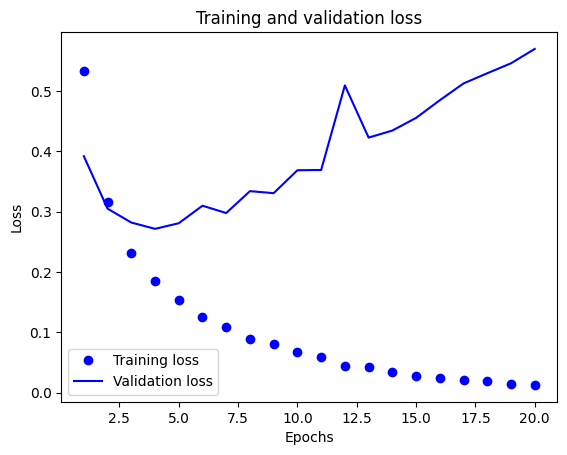

In [33]:
import matplotlib.pyplot as plt

loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

Osservando le due curve, possiamo notare come la training loss epoca dopo epoca diminuisce sempre di più (ed è quello che ci aspettiamo di ottenere quando si usa il gradiente). D'altro canto però, la validation loss, dalla quarta epoca in poi inizia a risalire, **suggerendo un overfitting da parte del modello**, questo indica che il modello sta over-ottimizando i dati di training, imparando dei pattern/caratteristiche legate solo ai dati di training, che non generalizzano/si presentano in dati al di fuori di quelli di training.

**Da qui quindi parte un pò la fase di tuning/test dove si provano varie modifiche per risolvere il problema/ genereare un modello migliore**

0) Si potrebbe provare a diminuire/aumentare le epoche. **La situazione non cambia**, solitamente si lavora sulle epoche quando già il modello è stabile, e quindi in quel caso si "gioca" sul numero di epoche. Ma in questo caso che il modello è in overfitting, variare le epoche poterà sempre allo stesso comportamento.

1) si potrebbe provare magari utilizzando 8 neuroni per layer, piuttosto che 16.
 **Il modello va comunque in overfitting**

2) Se ne metto invece 64?  
(ricordiamo che comunque dalla teoria, più neuroni inseriamo in un livello, più si rischia l'overfitting)

**Anche con 64 il risultato è lo stesso, la rete overfitta.**

3) Proviamo a cambiare la funzione di attivazione (**Proviamo con la tangente - TAHN**). **Provando, si ha che comunque la rete va in overfitting, in questo caso notiamo che la training loss parte con un valore piu alto, quindi ci aspettiamo che ci sia una discesa piu forte, cosa che succede**

3.1) Proviamo con una loss lineare? **Ma la situazione non cambia**

4) Arrivati a questo punto, le uniche cose non modificate sono l'architettura e i dati. **Proviamo ad agire sull'architettura, utilizzando il dropout**, in modo da "spegnere" alcuni neuroni. Proviamo con un dropout del 50% (in ogni layer spegnamo il 50% dei neuroni, solo la metà dei neuroni darà il proprio contributo.). **Il dropout rallenta la convergenza, che è un punto di forza nell'overfitting, ma il contro è che abbiamo un nuovo parametro da "tunare", quindi capire qual'è il giusto valore da assegnare al dropout.**

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.5596 - loss: 0.6751 - val_accuracy: 0.8328 - val_loss: 0.5854
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7080 - loss: 0.5784 - val_accuracy: 0.8543 - val_loss: 0.4854
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7800 - loss: 0.4905 - val_accuracy: 0.8743 - val_loss: 0.3959
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8338 - loss: 0.4232 - val_accuracy: 0.8838 - val_loss: 0.3477
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8679 - loss: 0.3658 - val_accuracy: 0.8844 - val_loss: 0.3174
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8924 - loss: 0.3258 - val_accuracy: 0.8882 - val_loss: 0.2903
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9055 - loss: 0.2850 - val_accuracy: 0.8799 - val_loss: 0.2916
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9244 - loss: 0.2512 - val_accuracy: 0.8886 -

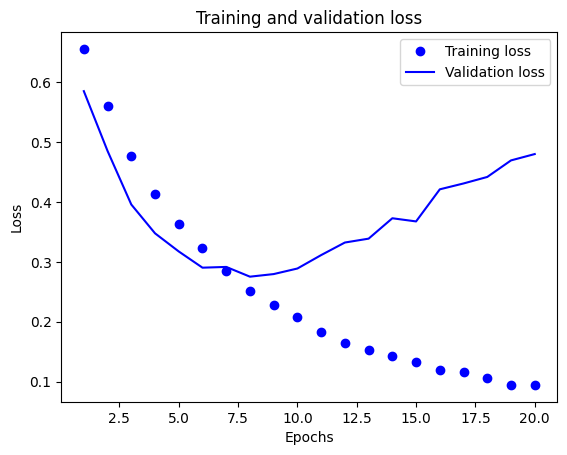

In [37]:
from tensorflow.keras.layers import Dropout

model = keras.Sequential([
layers.Dense(16, activation="relu"),
layers.Dropout(0.5),
layers.Dense(16, activation="relu"),
layers.Dropout(0.5),
layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
loss="binary_crossentropy",
metrics=["accuracy"])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

history_dict = history.history
history_dict.keys()

loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

**La rete inizia a comportarsi meglio, inizia a stabilizzarsi.**